In [1]:
import json, glob, pycm, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from operator import itemgetter
from IPython.display import display, Markdown

In [2]:
def display_experiment(experiment):
    display(Markdown(f'## {experiment["concept"]["label"]} ({experiment["concept"]["id"]})'))
    display(Markdown(experiment["concept"]["definition"]))
    display(Markdown("### Confusion matrix"))
    cm = pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"])
    df_cm = pd.DataFrame(cm.matrix).T.fillna(0)
    ax = sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")
    ax.set_title(experiment["concept"]["label"])
    ax.set(xlabel='LLM', ylabel='KG')
    plt.show()
    df = pd.DataFrame.from_records(experiment["data"])
    df_fp = df[((df["actual"] == 'negative') & (df["predicted"] == 'positive'))][["label", "description", "rationale"]]
    if len(df_fp) > 0:
        df_fp_styler = df_fp.style.set_properties(**{"text-align": "left", "vertical-align" : "top", "overflow-wrap": "break-word"}).hide(axis="index")
        display(Markdown("### False positives"))
        display(df_fp_styler)
    df_fn = df[((df["actual"] == 'positive') & (df["predicted"] == 'negative'))][["label", "description", "rationale"]]
    if len(df_fn) > 0:
        df_fn_styler = df_fn.style.set_properties(**{"text-align": "left", "vertical-align" : "top", "overflow-wrap": "break-word"}).hide(axis="index")
        display(Markdown("### False negatives"))
        display(df_fn_styler)

In [3]:
experiments = [ json.load(open(file, 'r')) for file in glob.glob('wd_experiments_v2/*/gpt-4*') ]

In [4]:
experiment_df = pd.DataFrame.from_records([ 
    { 
        "name": experiment["concept"]['label'], 
        "kappa": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).Kappa,
        "SOA9": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).SOA9,
        "ACC": f'{pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).Overall_ACC:.1%}',
        "FP": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).FP["positive"],
        "FN": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).FN["positive"],
        "POP": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).POP["positive"],
        "experiment": experiment,
    }
    for experiment in experiments ]).sort_values("kappa", ascending=False)
experiment_df[["name", "kappa", "SOA9", "ACC", "FP", "FN", "POP"]]

,name,kappa,SOA9,ACC,FP,FN,POP
0,Child,0.35,Low,67.5%,10,3,40


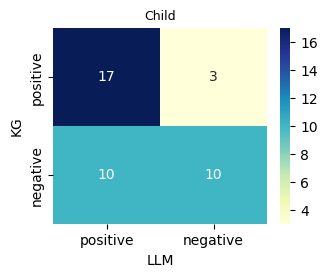

In [5]:
fig = plt.figure(figsize=(20,14))
gs = fig.add_gridspec(4, 5, hspace=0.5)
axes = gs.subplots()
cms = [ (experiment["name"], pycm.ConfusionMatrix(matrix=experiment["experiment"]["confusion_matrix"])) for experiment in experiment_df.to_dict('records')  ]
for ax, (name, cm) in zip(axes.flat, cms):
    df = pd.DataFrame(cm.matrix).T.fillna(0)
    sns.heatmap(df, annot=True, fmt='d', cmap="YlGnBu", ax=ax)
    ax.set_title(name, wrap=True, fontsize=9)
    ax.set(xlabel='LLM', ylabel='KG')
for ax in axes.flat[len(cms):]:
    ax.set_visible(False)
plt.show()

## Child (http://www.wikidata.org/entity/Q7569)

Child (noun):

1. A young human being below the age of puberty or below the legal age of majority.
2. A son or daughter of any age.
3. A person who is strongly influenced by or is a result of something. (e.g., a child of nature).
4. An immature or irresponsible person.
5. In computing, a subordinate element in a hierarchical system.

### Confusion matrix

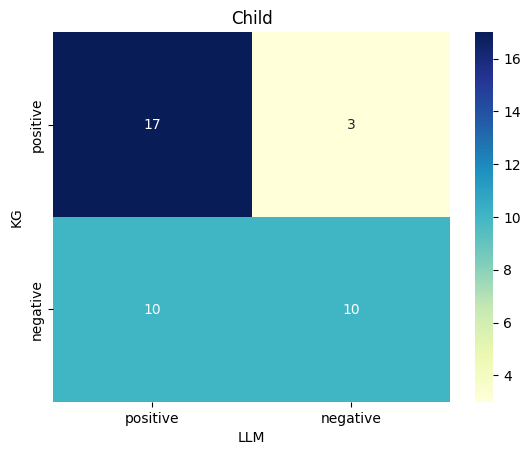

### False positives

label,description,rationale
Fill Adoptiu de Palafrugell,"""Fill Adoptiu de Palafrugell"" is a title of honor, known as ""Hijo Adoptivo de Palafrugell"" in Spanish and ""fils adoptif de Palafrugell"" in French, which translates to ""Adopted Son of Palafrugell"". This title is associated with entities Q551902 and Q43236661, and directly linked to entity Q43236683. The title has been subject to modifications, the latest of which occurred on April 17, 2018. It falls under the category represented by entity Q5897678 and is connected to entity Q41331557 via property P1027. It does not have any site links or identifiers in the Wikibase system and is represented by 4 statements.","The title ""Fill Adoptiu de Palafrugell"" translates to ""Adopted Son of Palafrugell"". The term ""son"" falls under the second definition of a child, which is ""a son or daughter of any age"". Therefore, based on this information, it can be argued that Fill Adoptiu de Palafrugell is a child."
Sailor Saturn,"Sailor Saturn, also known as Hotaru Tomoe, is a fictional character from the Sailor Moon franchise. She is primarily recognized as a magical girl, a character archetype in Japanese animation and comics. Sailor Saturn is a prominent character in various adaptations of the franchise, including the manga, anime, and Crystal series. She is also a popular choice for cosplay. The character is known under different names in multiple languages and has dedicated pages in various language editions of Wikipedia. She was created by Naoko Takeuchi for the Sailor Moon series. The character is also associated with the concept of death and rebirth, consistent with the associations of the planet Saturn in astrology.","Sailor Saturn, also known as Hotaru Tomoe, can be considered a child based on the second definition of the term. In the context of the Sailor Moon franchise, she is the 'daughter' of Professor Souichi Tomoe, making her a child in the sense of being someone's offspring. Furthermore, in the series, she is depicted as a young girl who is below the age of majority, which aligns with the first definition of a child."
Anonymous Wide Receivers Coachship,"The Anonymous Wide Receivers Coachship (Q96318584) is an endowed academic position at Stanford University. It is associated with the fields of American Football (Q41506) and Wide Receiver (Q41323), as well as the broader field of education (Q542). It falls under the categorizations of Academic Position (Q1363750) and Endowed Chair (Q41583). The Coachship is part of the Stanford Cardinal Football Project (Q96198959). Despite having seven statements, it has no site links or identifiers. The information was last modified on June 16, 2020.","The Anonymous Wide Receivers Coachship can be considered a 'child' in the context of the third definition provided: ""A person who is strongly influenced by or is a result of something."" In this case, the Coachship is a result of Stanford University's academic system and its focus on American Football and Wide Receiver education. It is also a 'child' of the Stanford Cardinal Football Project. Therefore, using this metaphorical understanding of the term 'child', the Anonymous Wide Receivers Coachship can be seen as a 'child' of these influences and systems."
Couch Family Defensive Backs Coachship,"The ""Couch Family Defensive Backs Coachship"" is an endowed academic position at Stanford University. The coachship is related to the fields of American football and defensive back, a position within the sport. The coachship falls under the larger categories of the Stanford Cardinal football team and the university itself. The entity has been described and labeled in English. The entity's data was last modified on June 16th, 2020.","The Couch Family Defensive Backs Coachship can be considered a ""child"" in the context of the third definition provided. This coachship is a result of, and therefore strongly influenced by, the fields of American football and defensive back. It is also a su

### False negatives

label,description,rationale
Chartiste,"""Chartiste"" is an entity described in the Wikidata database (wd:Q2961239). It was last modified on June 27, 2018 and its version number is 703485886. The entity has 2 statements, no sitelinks, and 1 identifier. The identifier is linked to the Bibliothèque nationale de France (wdtn:P268). The entity is classified under the category wd:Q48942. The term ""Chartiste"" is used in many languages, including but not limited to Afrikaans, Aragonese, Asturian, Bavarian, Breton, Catalan, Corsican, Czech, Welsh, Danish, German, English, Esperanto, Spanish, Estonian, Basque, Finnish, French, and more.","Based on the provided definition and information, it is not possible to argue that ""Chartiste"" is a child. The definition of a child pertains to human beings, their age, maturity, or influence, or to a subordinate element in a computing system. The description of ""Chartiste"" does not provide any information that would allow it to fit into any of these categories. It is described as an entity in a database, with no indication of age, human characteristics, immaturity, or subordination in a hierarchical system. Therefore, there is no rationale to assert that ""Chartiste"" is a child."
Dzieciątko,"""Dzieciątko"" (also known as ""Dźěćetko"" in German, ""Bescherkind"" in German, and ""sorbisches Christkind"" in German) is a Christmas custom originating from the Serbołużyczan culture. It is also recognized as a ""Weihnachtsbrauch"" in German which translates to ""Christmas tradition"". The custom is acknowledged in various language communities, including Polish and Russian, as indicated by its presence on their respective Wikipedia pages. The term ""Dzieciątko"" is also associated with multiple identifiers, such as wd:Q717040, wd:Q4271324, and wd:Q6581072. The entity was last modified on September 13, 2022.","The term ""Dzieciątko"" is associated with a Christmas custom originating from the Serbołużyczan culture. While the description does not provide specific details about the nature of this custom, it is often the case that cultural customs and traditions, especially those related to Christmas, involve personifications or symbolic representations. Given this, it is possible that ""Dzieciątko"" could be a personification or symbolic representation of a child within this cultural tradition. This would align with the third definition of a child as ""a person who is strongly influenced by or is a result of something."" In this case, ""Dzieciątko"" could be seen as a 'child' of the Serbołużyczan culture or the specific Christmas tradition it represents. However, without more specific information about the nature of the ""Dzieciątko"" custom, this argument is somewhat speculative."
Creche house Bayero University Kano state,"The Creche house Bayero University Kano state is a building (wd:Q118970518) situated within Bayero University in Kano state, Nigeria (wd:Q1033). The building is referred to as a ""Crech"" (skos:altLabel ""Crech""@en) and is located opposite the NANA HOSTEL Bayero University Kano state old site (wdt:P6375). It has a postal code of 700282 (wdt:P281). The building is also linked to the category ""Building"" on Wikimedia Commons ( schema:about wd:Q118970518). The page was last modified on the date ""2023-06-04T15:42:42Z"" (schema:dateModified). The building is represented by a point at the location (0.0, 0.0) (wdt:P625). An image of the front gate of the Creche house Bayero University Kano old site can be found on Wikimedia Commons (wdt:P18 ). The building is described as a ""Creche house in Bayero University Kano old site"" (schema:description).","Based on the provided definition of ""Child"", it is not possible to argue that the Creche house Bayero University Kano state is a ""Child"". The Creche house is a building, not a young human being, a son or daughter, a person influenced by something, an immature person, or a subordinate element in a hierarchical system. Therefore, it does not fi

In [6]:
for experiment in experiment_df["experiment"].values:
    display_experiment(experiment)